In [1]:
%reload_ext nb_black

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import plotly_express as px
from ipywidgets import interact

from sklearn import metrics

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

from sklearn.cluster import (
    KMeans,
    DBSCAN,
    AgglomerativeClustering,
)
from sklearn.mixture import GaussianMixture

<IPython.core.display.Javascript object>

# EDA

In [2]:
# the data set contains stats 10 min into diamond ranked games (~10k)
# data obtained from https://www.kaggle.com/bobbyscience/league-of-legends-diamond-ranked-games-10-min
lol = pd.read_csv("high_diamond_ranked_10min.csv")
lol.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


<IPython.core.display.Javascript object>

In [3]:
### Drop all red columns, focus solely on blue side.
blue_lol = lol[lol.columns.drop(list(lol.filter(regex="red")))]
blue_lol.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,17210,6.6,17039,195,36,643,-8,19.5,1721.0
1,4523371949,0,12,1,0,5,5,5,0,0,...,0,14712,6.6,16265,174,43,-2908,-1173,17.4,1471.2
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,16113,6.4,16221,186,46,-1172,-1033,18.6,1611.3
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,15157,7.0,17954,201,55,-1321,-7,20.1,1515.7
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,16400,7.0,18543,210,57,-1004,230,21.0,1640.0


<IPython.core.display.Javascript object>

In [4]:
# Eye balling the data, there are columns that are not necessary or redundant and can be dropped
# Able to get rid of these columns because there is another column of totals. Therefore by minute is unnecessary
blue_lol = blue_lol.drop(
    columns=[
        "gameId",
        "blueGoldPerMin",
        "blueGoldDiff",
        "blueCSPerMin",
        "blueAvgLevel",
        "blueExperienceDiff",
    ]
)

<IPython.core.display.Javascript object>

In [5]:
# Checking for any missing values within the dataset
# There does not appear to be any missing values in the data set.
blue_lol.isna().mean()

blueWins                        0.0
blueWardsPlaced                 0.0
blueWardsDestroyed              0.0
blueFirstBlood                  0.0
blueKills                       0.0
blueDeaths                      0.0
blueAssists                     0.0
blueEliteMonsters               0.0
blueDragons                     0.0
blueHeralds                     0.0
blueTowersDestroyed             0.0
blueTotalGold                   0.0
blueTotalExperience             0.0
blueTotalMinionsKilled          0.0
blueTotalJungleMinionsKilled    0.0
dtype: float64

<IPython.core.display.Javascript object>

In [6]:
# Making sure the data is numeric
blue_lol.dtypes

blueWins                        int64
blueWardsPlaced                 int64
blueWardsDestroyed              int64
blueFirstBlood                  int64
blueKills                       int64
blueDeaths                      int64
blueAssists                     int64
blueEliteMonsters               int64
blueDragons                     int64
blueHeralds                     int64
blueTowersDestroyed             int64
blueTotalGold                   int64
blueTotalExperience             int64
blueTotalMinionsKilled          int64
blueTotalJungleMinionsKilled    int64
dtype: object

<IPython.core.display.Javascript object>

In [7]:
# not enough information, I chose to only keep data from 1 and 0 tower kills, which will also place this in bin_cols
blue_lol["blueTowersDestroyed"].value_counts()

0    9415
1     429
2      27
3       7
4       1
Name: blueTowersDestroyed, dtype: int64

<IPython.core.display.Javascript object>

In [8]:
tower_counts = blue_lol["blueTowersDestroyed"].value_counts()
keep = tower_counts[tower_counts > 400].index
blue_lol = blue_lol[blue_lol["blueTowersDestroyed"].isin(keep)]

<IPython.core.display.Javascript object>

# Clustering

I will be performing 3 dimensionality reduction methods (PCA, t-SNE, UMAP) on 4 clustering methods (KMeans, DBSCAN, Agglomerative, GMM).

First I will apply PCA to the 4 different methods. Since I am applying PCA it is important to scale and standardize the data.

In [9]:
scaler = StandardScaler()
X_std = scaler.fit_transform(blue_lol)

<IPython.core.display.Javascript object>

## Applying PCA to the Data

In [10]:
# Computing the principal components
pca = PCA()
X_pca = pca.fit_transform(X_std)

<IPython.core.display.Javascript object>

In [11]:
pca.explained_variance_ratio_

array([2.63615377e-01, 1.39023505e-01, 1.09399601e-01, 7.60729176e-02,
       6.90720604e-02, 6.70107832e-02, 6.28352930e-02, 5.41898004e-02,
       5.00583999e-02, 4.74944385e-02, 3.34762755e-02, 1.73887245e-02,
       8.17474884e-03, 2.18807605e-03, 4.56760035e-33])

<IPython.core.display.Javascript object>

In [12]:
# I plan to use the amount of components that add up to 90% variance.
n_components = np.sum(np.cumsum(pca.explained_variance_ratio_) < 0.90)
X_pca = X_pca[:, :n_components]

<IPython.core.display.Javascript object>

In [13]:
# check to see the amount of components being used
# it appears 9 out of the 15 features add up to 90% variance
n_components

9

<IPython.core.display.Javascript object>

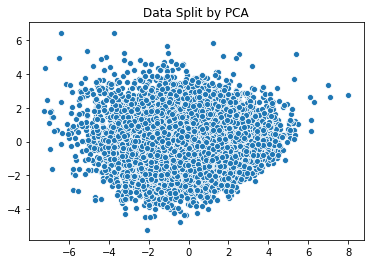

<IPython.core.display.Javascript object>

In [14]:
# adding a scatterplot to visualize how the data was split using PCA
# just eyeballing the plot there does not appear to be any noticeable clusters.
# curious to see how each clustering method will split the data.
sns.scatterplot(X_pca[:, 0], X_pca[:, 1])
plt.title("Data Split by PCA")
plt.show()

### Applying KMeans to the Data

To keep cluster results consistant I am applying a random state of 13 so when I close the notebook and come back to it at later times my results will remain the same. I am choosing to create 3-10 clusters and compare those results.

In [15]:
for c in range(3, 11):
    km = KMeans(n_clusters=c, random_state=13)
    km.fit(X_pca)
    labels = km.fit_predict(X_pca)
    print(
        f"The Silhouette Score for {c} clusters: "
        + str(metrics.silhouette_score(X_pca, labels, metric="euclidean"))
    )

The Silhouette Score for 3 clusters: 0.17751553632732925
The Silhouette Score for 4 clusters: 0.174171320226354
The Silhouette Score for 5 clusters: 0.17591190406998541
The Silhouette Score for 6 clusters: 0.1585760284556778
The Silhouette Score for 7 clusters: 0.1640629407248322
The Silhouette Score for 8 clusters: 0.16455040798973974
The Silhouette Score for 9 clusters: 0.17027904442946798
The Silhouette Score for 10 clusters: 0.16287427847191216


<IPython.core.display.Javascript object>

It appears KMeans with PCA and 3 clusters provides the best silhouette score of around 0.178. 

*Note: This score is relatively low.*

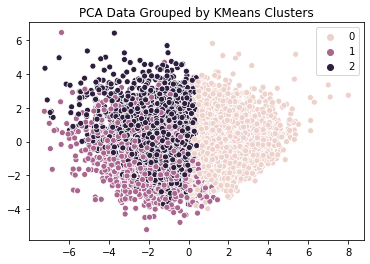

<IPython.core.display.Javascript object>

In [16]:
# Interesting to visualize how KMeans clusters the PCA data. (Using the K that resulted in highest Silhouette Score)
km = KMeans(n_clusters=3, random_state=13)
km.fit(X_pca)
labels = km.fit_predict(X_pca)
sns.scatterplot(X_pca[:, 0], X_pca[:, 1], hue=labels)
plt.title("PCA Data Grouped by KMeans Clusters")
plt.show()

### Applying DBSCAN to the Data

In [17]:
for e in (1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5):
    db = DBSCAN(eps=e)
    clusters = db.fit_predict(X_pca)
    print(
        "The number of clusters when epsilon = {} is: {} ".format(
            e, len(np.unique(clusters))
        )
    )
    print(str(len(np.unique(clusters))) + " cluster score: ")
    print(metrics.silhouette_score(X_pca, clusters, metric="euclidean"))

The number of clusters when epsilon = 1 is: 26 
26 cluster score: 
-0.13906358366571828
The number of clusters when epsilon = 1.5 is: 14 
14 cluster score: 
0.14739303978293924
The number of clusters when epsilon = 2 is: 10 
10 cluster score: 
0.17724452791750125
The number of clusters when epsilon = 2.5 is: 7 
7 cluster score: 
0.1852872463222325
The number of clusters when epsilon = 3 is: 3 
3 cluster score: 
0.3555809507181026
The number of clusters when epsilon = 3.5 is: 3 
3 cluster score: 
0.35767014679235165
The number of clusters when epsilon = 4 is: 3 
3 cluster score: 
0.35815449702653096
The number of clusters when epsilon = 4.5 is: 3 
3 cluster score: 
0.35896084731457545
The number of clusters when epsilon = 5 is: 2 
2 cluster score: 
0.5470454920663432


<IPython.core.display.Javascript object>

For DBSCAN I chose to only manipulate epsilon and leave the min samples alone. To my surprise, the Silhouette Scores obtained from this clustering method was much better than the other methods tested so far. The best epsilon is 5 and results in 2 clusters. This gives a Silhouette Score of 0.547.

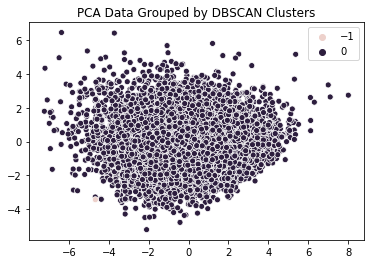

<IPython.core.display.Javascript object>

In [18]:
db = DBSCAN(eps=5)
clusters = db.fit_predict(X_pca)
sns.scatterplot(
    X_pca[:, 0], X_pca[:, 1], hue=clusters,
)
plt.title("PCA Data Grouped by DBSCAN Clusters")
plt.show()

### Applying Agglomerative Clustering to the Data

For Agglomerative clustering since there are three ways to determine linkage (complete, average, ward), I will be creating 3-10 clusters for each of the three distance measurements.

In [19]:
for c in range(3, 11):
    agg_clstr = AgglomerativeClustering(
        linkage="complete", affinity="cosine", n_clusters=c
    )
    clusters = agg_clstr.fit_predict(X_pca)

    print(
        "The Silhouette Score for "
        + str(c)
        + " clusters is: "
        + str(metrics.silhouette_score(X_pca, clusters, metric="euclidean"))
    )

The Silhouette Score for 3 clusters is: 0.09001934310702729
The Silhouette Score for 4 clusters is: 0.11991539369910201
The Silhouette Score for 5 clusters is: 0.06609544253693514
The Silhouette Score for 6 clusters is: 0.04219258073056444
The Silhouette Score for 7 clusters is: 0.04612100051727293
The Silhouette Score for 8 clusters is: 0.04484446937320177
The Silhouette Score for 9 clusters is: 0.07202883401986299
The Silhouette Score for 10 clusters is: 0.07641897618938209


<IPython.core.display.Javascript object>

In [20]:
for c in range(4, 11):
    agg_clstr = AgglomerativeClustering(
        linkage="average", affinity="cosine", n_clusters=c
    )
    clusters = agg_clstr.fit_predict(X_pca)

    print(
        "The Silhouette Score for "
        + str(c)
        + " clusters is:"
        + str(metrics.silhouette_score(X_pca, clusters, metric="euclidean"))
    )

The Silhouette Score for 4 clusters is:0.16184144774615958
The Silhouette Score for 5 clusters is:0.1233482760822222
The Silhouette Score for 6 clusters is:0.15308406440632782
The Silhouette Score for 7 clusters is:0.14755885940473779
The Silhouette Score for 8 clusters is:0.14559854853705745
The Silhouette Score for 9 clusters is:0.13021519019954858
The Silhouette Score for 10 clusters is:0.11995913423793382


<IPython.core.display.Javascript object>

In [21]:
for c in range(4, 11):
    agg_clstr = AgglomerativeClustering(
        linkage="ward", affinity="euclidean", n_clusters=c
    )
    clusters = agg_clstr.fit_predict(X_pca)

    print(
        "The Silhouette Score for "
        + str(c)
        + " clusters is:"
        + str(metrics.silhouette_score(X_pca, clusters, metric="euclidean"))
    )

The Silhouette Score for 4 clusters is:0.1532527334233306
The Silhouette Score for 5 clusters is:0.17018040774754256
The Silhouette Score for 6 clusters is:0.16115705352567145
The Silhouette Score for 7 clusters is:0.1467820637214655
The Silhouette Score for 8 clusters is:0.14834859009156706
The Silhouette Score for 9 clusters is:0.11438776227717598
The Silhouette Score for 10 clusters is:0.1182766085820967


<IPython.core.display.Javascript object>

After comparing the results it is clear Agglomerative Clustering with 5 clusters and ward linkage provides the best Silhouette Score of 0.170.

*Note: this score is still relatively low*

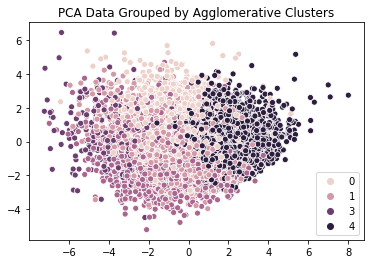

<IPython.core.display.Javascript object>

In [22]:
agg_clstr = AgglomerativeClustering(linkage="ward", affinity="euclidean", n_clusters=5)
clusters = agg_clstr.fit_predict(X_pca)
sns.scatterplot(
    X_pca[:, 0], X_pca[:, 1], hue=clusters,
)
plt.title("PCA Data Grouped by Agglomerative Clusters")
plt.show()

### Applying Gaussian Mixture Model to the Data

In [23]:
for c in range(3, 11):
    gauss = GaussianMixture(n_components=c, random_state=13)
    clusters = gauss.fit_predict(X_pca)
    print(
        "The Silhouette Score for "
        + str(c)
        + " clusters is:"
        + str(metrics.silhouette_score(X_pca, clusters, metric="euclidean"))
    )

The Silhouette Score for 3 clusters is:0.1798293947077883
The Silhouette Score for 4 clusters is:0.16079053875207625
The Silhouette Score for 5 clusters is:0.15205186132718806
The Silhouette Score for 6 clusters is:0.14363874566492935
The Silhouette Score for 7 clusters is:0.12459468379358489
The Silhouette Score for 8 clusters is:0.13164980603507287
The Silhouette Score for 9 clusters is:0.1197192990338002
The Silhouette Score for 10 clusters is:0.10165722263946232


<IPython.core.display.Javascript object>

The best Silhouette Score comes from GMM with 3 clusters. The score is around 0.180, which is slightly better than KMeans and Agglomerative clustering, but still a pretty low score compared to DBSCAN.

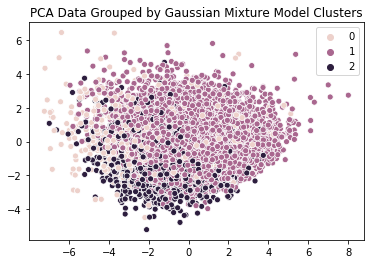

<IPython.core.display.Javascript object>

In [24]:
gauss = GaussianMixture(n_components=3, random_state=13)
clusters = gauss.fit_predict(X_pca)

sns.scatterplot(
    X_pca[:, 0], X_pca[:, 1], hue=clusters,
)
plt.title("PCA Data Grouped by Gaussian Mixture Model Clusters")
plt.show()

Comparing all of the clustering methods best scores, we see when applying PCA to the data DBSCAN has the best Silhouette score by a long shot (0.547).

## Applying t-SNE to the Data

In [25]:
# Going for a more global approach. Higher perplexity
tsne = TSNE(n_components=2, perplexity=50)
X_tsne = tsne.fit_transform(X_std)

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Data Split by t-SNE')

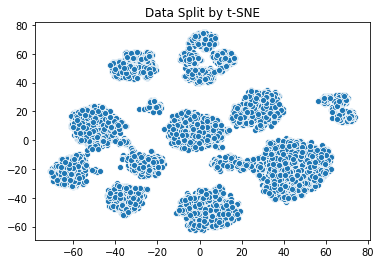

<IPython.core.display.Javascript object>

In [26]:
# adding a scatterplot to visualize how the data was split using t-SNE
# just eyeballing the plot there appears to be many noticeable clusters.
# curious to see how each clustering method will split the data.
sns.scatterplot(X_tsne[:, 0], X_tsne[:, 1])
plt.title("Data Split by t-SNE")

I will be using the same parameters for each clustering model.

### Applying KMeans to the Data

In [27]:
for c in range(3, 11):
    km = KMeans(n_clusters=c, random_state=13)
    km.fit(X_tsne)
    labels = km.fit_predict(X_tsne)
    print(
        f"The Silhouette Score for {c} clusters: "
        + str(metrics.silhouette_score(X_tsne, labels, metric="euclidean"))
    )

The Silhouette Score for 3 clusters: 0.42579216
The Silhouette Score for 4 clusters: 0.40669176
The Silhouette Score for 5 clusters: 0.46755275
The Silhouette Score for 6 clusters: 0.4944979
The Silhouette Score for 7 clusters: 0.51087385
The Silhouette Score for 8 clusters: 0.529089
The Silhouette Score for 9 clusters: 0.5534471
The Silhouette Score for 10 clusters: 0.5827098


<IPython.core.display.Javascript object>

Just comparing KMeans with PCA and KMeans with t-SNE its clear t-SNE provides much better Silhouette Scores. We see that KMeans with 10 clusters also provides the best (and a much much higher) Silhouette Score (0.582).

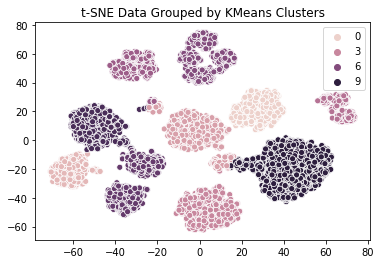

<IPython.core.display.Javascript object>

In [28]:
# Interesting to visualize how KMeans clusters the t-SNE data. (Using the K that resulted in highest Silhouette Score)
km = KMeans(n_clusters=10, random_state=13)
km.fit(X_tsne)
labels = km.fit_predict(X_tsne)
sns.scatterplot(X_tsne[:, 0], X_tsne[:, 1], hue=labels)
plt.title("t-SNE Data Grouped by KMeans Clusters")
plt.show()

### Applying DBSCAN to the Data

In [29]:
for e in (1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5):
    db = DBSCAN(eps=e)
    clusters = db.fit_predict(X_tsne)
    print(
        "The number of clusters when epsilon = {} is: {} ".format(
            e, len(np.unique(clusters))
        )
    )
    print(str(len(np.unique(clusters))) + " cluster score: ")
    print(metrics.silhouette_score(X_tsne, clusters, metric="euclidean"))

The number of clusters when epsilon = 1 is: 162 
162 cluster score: 
-0.058818676
The number of clusters when epsilon = 1.5 is: 35 
35 cluster score: 
0.29350296
The number of clusters when epsilon = 2 is: 20 
20 cluster score: 
0.4054613
The number of clusters when epsilon = 2.5 is: 15 
15 cluster score: 
0.5636081
The number of clusters when epsilon = 3 is: 12 
12 cluster score: 
0.5132488
The number of clusters when epsilon = 3.5 is: 11 
11 cluster score: 
0.42236155
The number of clusters when epsilon = 4 is: 10 
10 cluster score: 
0.4847864
The number of clusters when epsilon = 4.5 is: 9 
9 cluster score: 
0.42645922
The number of clusters when epsilon = 5 is: 9 
9 cluster score: 
0.42645922


<IPython.core.display.Javascript object>

Using the same epsilons as before, I noticed the scores are not as good as PCA. This could result in not using the most optimal epsilon value. However, the Silhouette Scores are still relatively high compared the majority of the scores obtained when using PCA.

The best Silhouette Score comes from using an epsilon of 2 and results in 19 clusters (0.491).

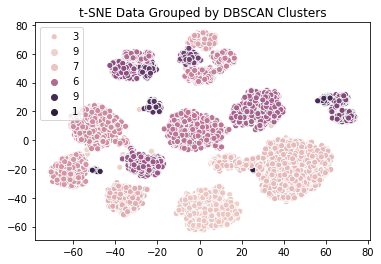

<IPython.core.display.Javascript object>

In [30]:
db = DBSCAN(eps=2)
clusters = db.fit_predict(X_tsne)
sns.scatterplot(
    X_tsne[:, 0], X_tsne[:, 1], hue=clusters,
)
plt.title("t-SNE Data Grouped by DBSCAN Clusters")
plt.legend(labels)
plt.show()

### Applying Agglomerative Clustering to the Data

In [31]:
for c in range(3, 11):
    agg_clstr = AgglomerativeClustering(
        linkage="complete", affinity="cosine", n_clusters=c
    )
    clusters = agg_clstr.fit_predict(X_tsne)

    print(
        "The Silhouette Score for "
        + str(c)
        + " clusters is: "
        + str(metrics.silhouette_score(X_tsne, clusters, metric="euclidean"))
    )

The Silhouette Score for 3 clusters is: 0.38442212
The Silhouette Score for 4 clusters is: 0.38659537
The Silhouette Score for 5 clusters is: 0.36068788
The Silhouette Score for 6 clusters is: 0.28760898
The Silhouette Score for 7 clusters is: 0.26581135
The Silhouette Score for 8 clusters is: 0.29181427
The Silhouette Score for 9 clusters is: 0.3152243
The Silhouette Score for 10 clusters is: 0.2961534


<IPython.core.display.Javascript object>

In [32]:
for c in range(4, 11):
    agg_clstr = AgglomerativeClustering(
        linkage="average", affinity="cosine", n_clusters=c
    )
    clusters = agg_clstr.fit_predict(X_tsne)

    print(
        "The Silhouette Score for "
        + str(c)
        + " clusters is:"
        + str(metrics.silhouette_score(X_tsne, clusters, metric="euclidean"))
    )

The Silhouette Score for 4 clusters is:0.40635872
The Silhouette Score for 5 clusters is:0.4315434
The Silhouette Score for 6 clusters is:0.41967356
The Silhouette Score for 7 clusters is:0.4262616
The Silhouette Score for 8 clusters is:0.42150497
The Silhouette Score for 9 clusters is:0.39392674
The Silhouette Score for 10 clusters is:0.3505486


<IPython.core.display.Javascript object>

In [33]:
for c in range(4, 11):
    agg_clstr = AgglomerativeClustering(
        linkage="ward", affinity="euclidean", n_clusters=c
    )
    clusters = agg_clstr.fit_predict(X_tsne)

    print(
        "The Silhouette Score for "
        + str(c)
        + " clusters is:"
        + str(metrics.silhouette_score(X_tsne, clusters, metric="euclidean"))
    )

The Silhouette Score for 4 clusters is:0.44230306
The Silhouette Score for 5 clusters is:0.45998305
The Silhouette Score for 6 clusters is:0.48000228
The Silhouette Score for 7 clusters is:0.5054975
The Silhouette Score for 8 clusters is:0.5274096
The Silhouette Score for 9 clusters is:0.5505204
The Silhouette Score for 10 clusters is:0.57985306


<IPython.core.display.Javascript object>

Once again, the Silhouette Scores obtained when using t-SNE are much better compared to the scores obtained using PCA. Similarly to PCA, the linkage measurement that gave the best score was ward linkage. This time the model resulted in 10 clusters and gave a score of around 0.559.

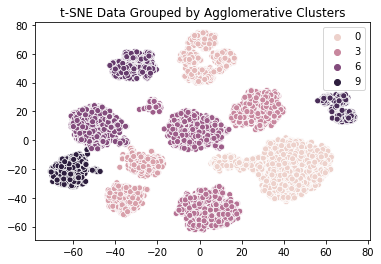

<IPython.core.display.Javascript object>

In [34]:
agg_clstr = AgglomerativeClustering(linkage="ward", affinity="euclidean", n_clusters=10)
clusters = agg_clstr.fit_predict(X_tsne)
sns.scatterplot(
    X_tsne[:, 0], X_tsne[:, 1], hue=clusters,
)
plt.title("t-SNE Data Grouped by Agglomerative Clusters")
plt.show()

### Applying Gaussian Mixture Model to the Data

In [35]:
for c in range(3, 11):
    gauss = GaussianMixture(n_components=c, random_state=13)
    clusters = gauss.fit_predict(X_tsne)
    print(
        "The Silhouette Score for "
        + str(c)
        + " clusters is:"
        + str(metrics.silhouette_score(X_tsne, clusters, metric="euclidean"))
    )

The Silhouette Score for 3 clusters is:0.4183046
The Silhouette Score for 4 clusters is:0.4354513
The Silhouette Score for 5 clusters is:0.44269177
The Silhouette Score for 6 clusters is:0.4897826
The Silhouette Score for 7 clusters is:0.5046062
The Silhouette Score for 8 clusters is:0.5244155
The Silhouette Score for 9 clusters is:0.55490243
The Silhouette Score for 10 clusters is:0.5814268


<IPython.core.display.Javascript object>

GMM with 10 clusters results in the highest Silhouette Score (0.566). I'm starting to notice a pattern that the higher the clusters, the better the Silhouette Score. 

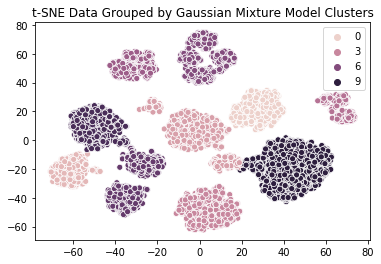

<IPython.core.display.Javascript object>

In [36]:
gauss = GaussianMixture(n_components=10, random_state=13)
clusters = gauss.fit_predict(X_tsne)

sns.scatterplot(
    X_tsne[:, 0], X_tsne[:, 1], hue=clusters,
)
plt.title("t-SNE Data Grouped by Gaussian Mixture Model Clusters")
plt.show()

Concluding thoughts for t-SNE:

The data was split up much more effectively than when I applied PCA

This could be the reason for much higher Silhouette Scores

Run time was similar to when I used PCA so time was not an issue when using t-SNE

**When comparing all of the models' Silhouette Score, the best score was obtained when using KMeans with 10 clusters (0.582)**

## Applying UMAP to the Data

In [37]:
# Once again, I am choosing to go with a more global approach. Resulting in a higher n_neighbors
umap_results = umap.UMAP(n_components=2, n_neighbors=20)
X_umap = umap_results.fit_transform(X_std)

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Data Split by UMAP')

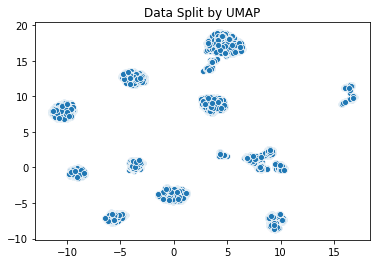

<IPython.core.display.Javascript object>

In [38]:
# adding a scatterplot to visualize how the data was split using UMAP
# just eyeballing the plot there appears to be many noticeable clusters.
# curious to see how each clustering method will split the data.
sns.scatterplot(X_umap[:, 0], X_umap[:, 1])
plt.title("Data Split by UMAP")

Once again, I will be using the same parameters for each clustering model.

### Applying KMeans to the Data

In [39]:
for c in range(3, 11):
    km = KMeans(n_clusters=c, random_state=13)
    km.fit(X_umap)
    labels = km.fit_predict(X_umap)
    print(
        f"The Silhouette Score for {c} clusters: "
        + str(metrics.silhouette_score(X_umap, labels, metric="euclidean"))
    )

The Silhouette Score for 3 clusters: 0.48952344
The Silhouette Score for 4 clusters: 0.5490662
The Silhouette Score for 5 clusters: 0.5929982
The Silhouette Score for 6 clusters: 0.6353665
The Silhouette Score for 7 clusters: 0.6577166
The Silhouette Score for 8 clusters: 0.7285267
The Silhouette Score for 9 clusters: 0.7504744
The Silhouette Score for 10 clusters: 0.79534936


<IPython.core.display.Javascript object>

UMAP seems to be resulting in the highest Silhouette Scores. These scores are much higher than PCA and even higher than the results obtained from t-SNE. Once again, the best score comes from using n_clusters = 10 (0.801)

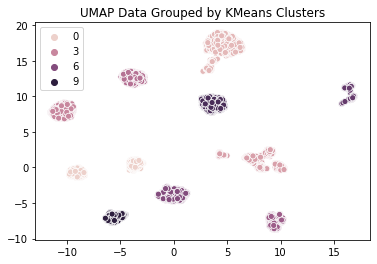

<IPython.core.display.Javascript object>

In [40]:
# Interesting to visualize how KMeans clusters the t-SNE data. (Using the K that resulted in highest Silhouette Score)
km = KMeans(n_clusters=10, random_state=13)
km.fit(X_umap)
labels = km.fit_predict(X_umap)
sns.scatterplot(X_umap[:, 0], X_umap[:, 1], hue=labels)
plt.title("UMAP Data Grouped by KMeans Clusters")
plt.show()

### Applying DBSCAN to the Data

In [41]:
for e in (1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5):
    db = DBSCAN(eps=e)
    clusters = db.fit_predict(X_umap)
    print(
        "The number of clusters when epsilon = {} is: {} ".format(
            e, len(np.unique(clusters))
        )
    )
    print(str(len(np.unique(clusters))) + " cluster score: ")
    print(metrics.silhouette_score(X_umap, clusters, metric="euclidean"))

The number of clusters when epsilon = 1 is: 12 
12 cluster score: 
0.8164647
The number of clusters when epsilon = 1.5 is: 12 
12 cluster score: 
0.8164647
The number of clusters when epsilon = 2 is: 11 
11 cluster score: 
0.8329651
The number of clusters when epsilon = 2.5 is: 11 
11 cluster score: 
0.8329651
The number of clusters when epsilon = 3 is: 11 
11 cluster score: 
0.8329651
The number of clusters when epsilon = 3.5 is: 11 
11 cluster score: 
0.8329651
The number of clusters when epsilon = 4 is: 8 
8 cluster score: 
0.63531333
The number of clusters when epsilon = 4.5 is: 7 
7 cluster score: 
0.6253582
The number of clusters when epsilon = 5 is: 7 
7 cluster score: 
0.6253582


<IPython.core.display.Javascript object>

I notice that I often have trouble with DBSCAN because of the parameters. I think in order to create the most optimal model it would be important to change both epsilon and min samples. This could be taken into consideration for the next round of clustering. However, for this round, using the same parameters for each dimensionality reduction method, I obtained the best Silhouette Score using an epsilon of either 1,1.5,2,2.5,or 3, each giving a score of around 0.828. Still, the score is much higher than before and provides pretty good results, but maybe they could be higher with more experimentation and exploration.

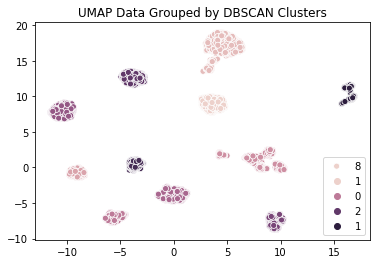

<IPython.core.display.Javascript object>

In [42]:
db = DBSCAN(eps=2)
clusters = db.fit_predict(X_umap)
sns.scatterplot(
    X_umap[:, 0], X_umap[:, 1], hue=clusters,
)
plt.title("UMAP Data Grouped by DBSCAN Clusters")
plt.legend(labels)
plt.show()

### Applying Agglomerative Clustering to the Data

In [43]:
for c in range(3, 11):
    agg_clstr = AgglomerativeClustering(
        linkage="complete", affinity="cosine", n_clusters=c
    )
    clusters = agg_clstr.fit_predict(X_umap)

    print(
        "The Silhouette Score for "
        + str(c)
        + " clusters is: "
        + str(metrics.silhouette_score(X_umap, clusters, metric="euclidean"))
    )

The Silhouette Score for 3 clusters is: 0.3448556
The Silhouette Score for 4 clusters is: 0.47346213
The Silhouette Score for 5 clusters is: 0.5215132
The Silhouette Score for 6 clusters is: 0.5554382
The Silhouette Score for 7 clusters is: 0.59623265
The Silhouette Score for 8 clusters is: 0.6281245
The Silhouette Score for 9 clusters is: 0.57884306
The Silhouette Score for 10 clusters is: 0.5671031


<IPython.core.display.Javascript object>

In [44]:
for c in range(4, 11):
    agg_clstr = AgglomerativeClustering(
        linkage="average", affinity="cosine", n_clusters=c
    )
    clusters = agg_clstr.fit_predict(X_umap)

    print(
        "The Silhouette Score for "
        + str(c)
        + " clusters is:"
        + str(metrics.silhouette_score(X_umap, clusters, metric="euclidean"))
    )

The Silhouette Score for 4 clusters is:0.50785667
The Silhouette Score for 5 clusters is:0.52198416
The Silhouette Score for 6 clusters is:0.53432727
The Silhouette Score for 7 clusters is:0.59150916
The Silhouette Score for 8 clusters is:0.6281245
The Silhouette Score for 9 clusters is:0.67577875
The Silhouette Score for 10 clusters is:0.6276073


<IPython.core.display.Javascript object>

In [45]:
for c in range(4, 11):
    agg_clstr = AgglomerativeClustering(
        linkage="ward", affinity="euclidean", n_clusters=c
    )
    clusters = agg_clstr.fit_predict(X_umap)

    print(
        "The Silhouette Score for "
        + str(c)
        + " clusters is:"
        + str(metrics.silhouette_score(X_umap, clusters, metric="euclidean"))
    )

The Silhouette Score for 4 clusters is:0.5490662
The Silhouette Score for 5 clusters is:0.5929982
The Silhouette Score for 6 clusters is:0.6353665
The Silhouette Score for 7 clusters is:0.68736744
The Silhouette Score for 8 clusters is:0.7285267
The Silhouette Score for 9 clusters is:0.7504744
The Silhouette Score for 10 clusters is:0.79534936


<IPython.core.display.Javascript object>

Just like the previous Agglomerative Clustering models, the best Silhouette Score comes from using ward linkage and having 10 clusters. This time the score is around 0.801.

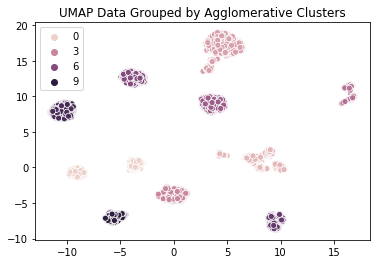

<IPython.core.display.Javascript object>

In [46]:
agg_clstr = AgglomerativeClustering(linkage="ward", affinity="euclidean", n_clusters=10)
clusters = agg_clstr.fit_predict(X_umap)
sns.scatterplot(
    X_umap[:, 0], X_umap[:, 1], hue=clusters,
)
plt.title("UMAP Data Grouped by Agglomerative Clusters")
plt.show()

### Applying Gaussian Mixture Model to the Data

In [47]:
for c in range(3, 11):
    gauss = GaussianMixture(n_components=c, random_state=13)
    clusters = gauss.fit_predict(X_umap)
    print(
        "The Silhouette Score for "
        + str(c)
        + " clusters is:"
        + str(metrics.silhouette_score(X_umap, clusters, metric="euclidean"))
    )

The Silhouette Score for 3 clusters is:0.48285776
The Silhouette Score for 4 clusters is:0.5408097
The Silhouette Score for 5 clusters is:0.49254245
The Silhouette Score for 6 clusters is:0.55806684
The Silhouette Score for 7 clusters is:0.6540987
The Silhouette Score for 8 clusters is:0.68675715
The Silhouette Score for 9 clusters is:0.7388549
The Silhouette Score for 10 clusters is:0.78457123


<IPython.core.display.Javascript object>

The Silhouette Scores are once again much higher when using UMAP. I believe the reason for this is because of how the data was split so effectively when using UMAP. There is the same pattern that the more amount of clusters results in a higher Silhouette Score (to an extent). The highest score obtained from using GMM is 0.771 and includes 10 clusters.

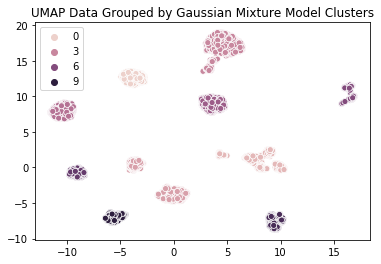

<IPython.core.display.Javascript object>

In [48]:
gauss = GaussianMixture(n_components=10, random_state=13)
clusters = gauss.fit_predict(X_umap)

sns.scatterplot(
    X_umap[:, 0], X_umap[:, 1], hue=clusters,
)
plt.title("UMAP Data Grouped by Gaussian Mixture Model Clusters")
plt.show()

Concluding thoughts for UMAP:

The scores for **ALL** of the models were much higher when using UMAP when compared to PCA and t-SNE

I wanted to take a more global approach when using UMAP so I chose to use n_neighbors = 20, however I realized the value can go up to 100. So for future clustering, I can increase this value and see how my Silhouette Scores change.

The best Silhouette Score was obtained from using DBSCAN. I obtained a score of around **0.828**

When using DBSCAN I used the same parameters as before (for PCA and t-SNE) and I only tuned the epsilon value. 

I think the Silhouette Score can be improved if I use different epsilon values, and also mess around with other parameters. This will go into consideration for future clustering. 

**Overall, out of all the dimensionality reduction methods and clustering algorithms, the best Silhouette Score was obtained from using DBSCAN with UMAP**

Therefore, this clustering algorithm and dimensionality reduction method is what I will be using for further analysis.

# Final Clustering

## DBSCAN with UMAP

In [49]:
umap_results = umap.UMAP(n_components=2, n_neighbors=20)
X_umap = umap_results.fit_transform(X_std)
db = DBSCAN(eps=1)
clusters = db.fit_predict(X_umap)

<IPython.core.display.Javascript object>

In [50]:
# adding the cluster labels to the original dataframe
blue_lol["Cluster"] = db.labels_

<IPython.core.display.Javascript object>

In [51]:
blue_lol.head()

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,Cluster
0,0,28,2,1,9,6,11,0,0,0,0,17210,17039,195,36,0
1,0,12,1,0,5,5,5,0,0,0,0,14712,16265,174,43,1
2,0,15,0,0,7,11,4,1,1,0,0,16113,16221,186,46,2
3,0,43,1,0,4,5,5,1,0,1,0,15157,17954,201,55,3
4,0,75,4,0,6,6,6,0,0,0,0,16400,18543,210,57,1


<IPython.core.display.Javascript object>

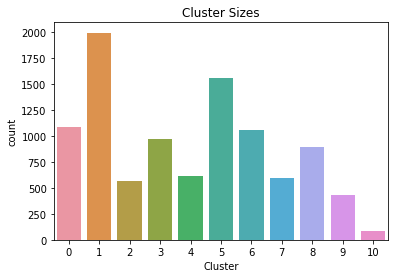

<IPython.core.display.Javascript object>

In [52]:
# Create bar chart for cluster sizes
# It seems like most of the clusters are around the same size with clusters 1 and 11 being exceptions.
sns.countplot(blue_lol["Cluster"])
plt.title("Cluster Sizes")
plt.show()

In [53]:
# creating a table of cluster means to look for any patterns
clst_means = blue_lol.groupby("Cluster").mean()
clst_means.style.background_gradient()

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled
Cluster,,,,,,,,,,,,,,,
0,0.000000,19.538745,2.625461,1.000000,5.743542,6.879151,6.208487,0.000000,0.000000,0.000000,0.000000,16133.272140,17475.297048,212.796125,47.862546
1,0.011044,24.412149,2.468876,0.022590,4.450803,7.789157,4.601406,0.001004,0.000502,0.000502,0.000000,15422.831827,17227.965863,209.203815,48.247992
2,0.000000,21.209507,2.698944,0.000000,5.132042,7.112676,5.755282,1.000000,1.000000,0.000000,0.000000,15780.359155,17480.799296,211.279930,50.853873
3,0.486010,22.179275,2.787565,0.511917,6.095337,5.968912,6.238342,1.000000,0.000000,1.000000,0.000000,16519.702591,18092.458031,218.311917,51.723316
4,1.000000,21.428105,2.915033,0.000000,6.521242,5.377451,7.334967,1.000000,1.000000,0.000000,0.000000,16674.459150,18324.807190,221.062092,52.787582
5,0.680591,23.760283,2.807841,0.991645,7.261568,5.042416,8.073265,1.001928,0.999357,0.002571,0.000000,17007.402314,18237.242288,219.541131,51.849614
6,1.000000,20.342479,2.715232,0.999054,7.245033,5.016083,7.860927,0.000000,0.000000,0.000000,0.000000,17119.362346,18330.030274,222.021760,49.979186
7,0.709030,22.556856,2.780936,0.658863,6.988294,5.023411,7.397993,2.000000,1.000000,1.000000,0.000000,16997.672241,18485.013378,221.148829,55.762542
8,1.000000,21.632107,2.845039,0.001115,6.188406,6.150502,6.602007,0.000000,0.000000,0.000000,0.000000,16496.783724,18093.316611,217.853958,50.400223


<IPython.core.display.Javascript object>

In [54]:
# wrap code for creating interactive bar charts
def ibarchart(df, x, y, order=None, title=""):
    fig = px.bar(df, x=x, y=y, title=title, template="none")

    fig.update_traces(
        marker_color="lightskyblue", marker_line_color="blue", marker_line_width=1
    )

    fig.update_layout(xaxis={"categoryorder": "array", "categoryarray": order})

    fig.show()

<IPython.core.display.Javascript object>

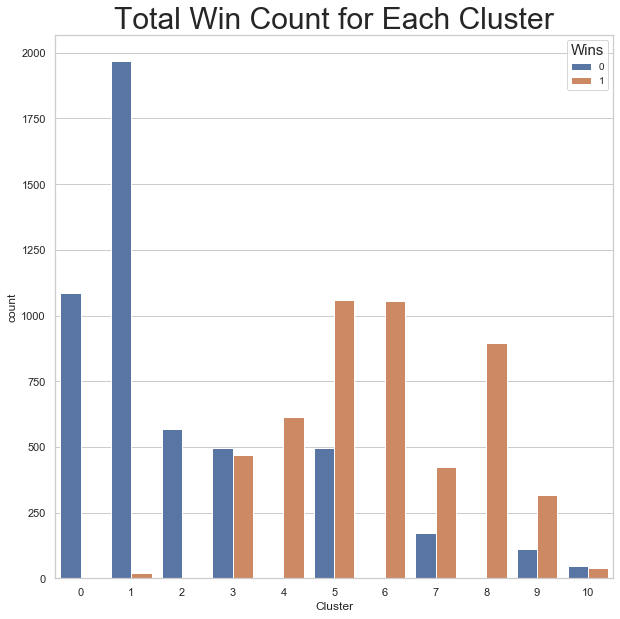

<IPython.core.display.Javascript object>

In [115]:
# Creating a bar plot to show total wins in each cluster. Need to increase font size of each axis labels.
sns.countplot(data=blue_lol, x="Cluster", hue="blueWins")
plt.legend(
    loc="upper right", title="Wins", fontsize=10, title_fontsize=15,
)
sns.set(rc={"figure.figsize": (10, 10)})
sns.set_style("whitegrid")
plt.title("Total Win Count for Each Cluster", fontsize=30)
plt.show()

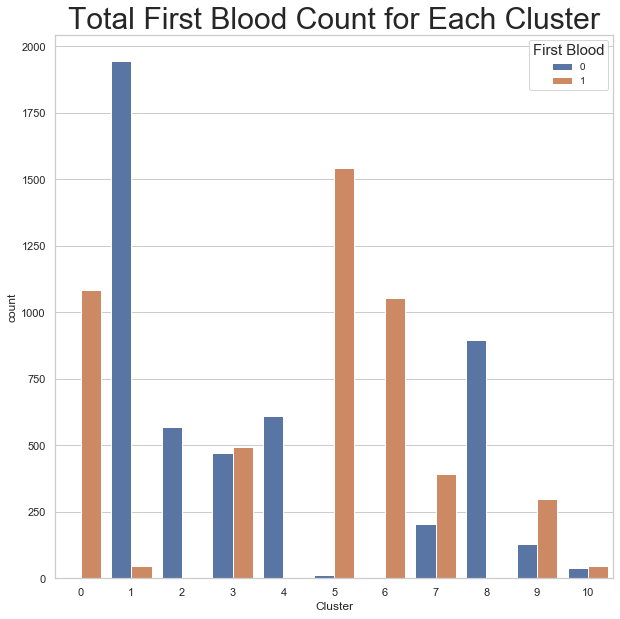

<IPython.core.display.Javascript object>

In [116]:
# Creating a bar plot to show total first bloods in each cluster. Need to increase font size of each axis labels.
sns.countplot(data=blue_lol, x="Cluster", hue="blueFirstBlood")
plt.legend(
    loc="upper right", title="First Blood", fontsize=10, title_fontsize=15,
)
sns.set(rc={"figure.figsize": (10, 10)})
sns.set_style("whitegrid")
plt.title("Total First Blood Count for Each Cluster", fontsize=30)
plt.show()

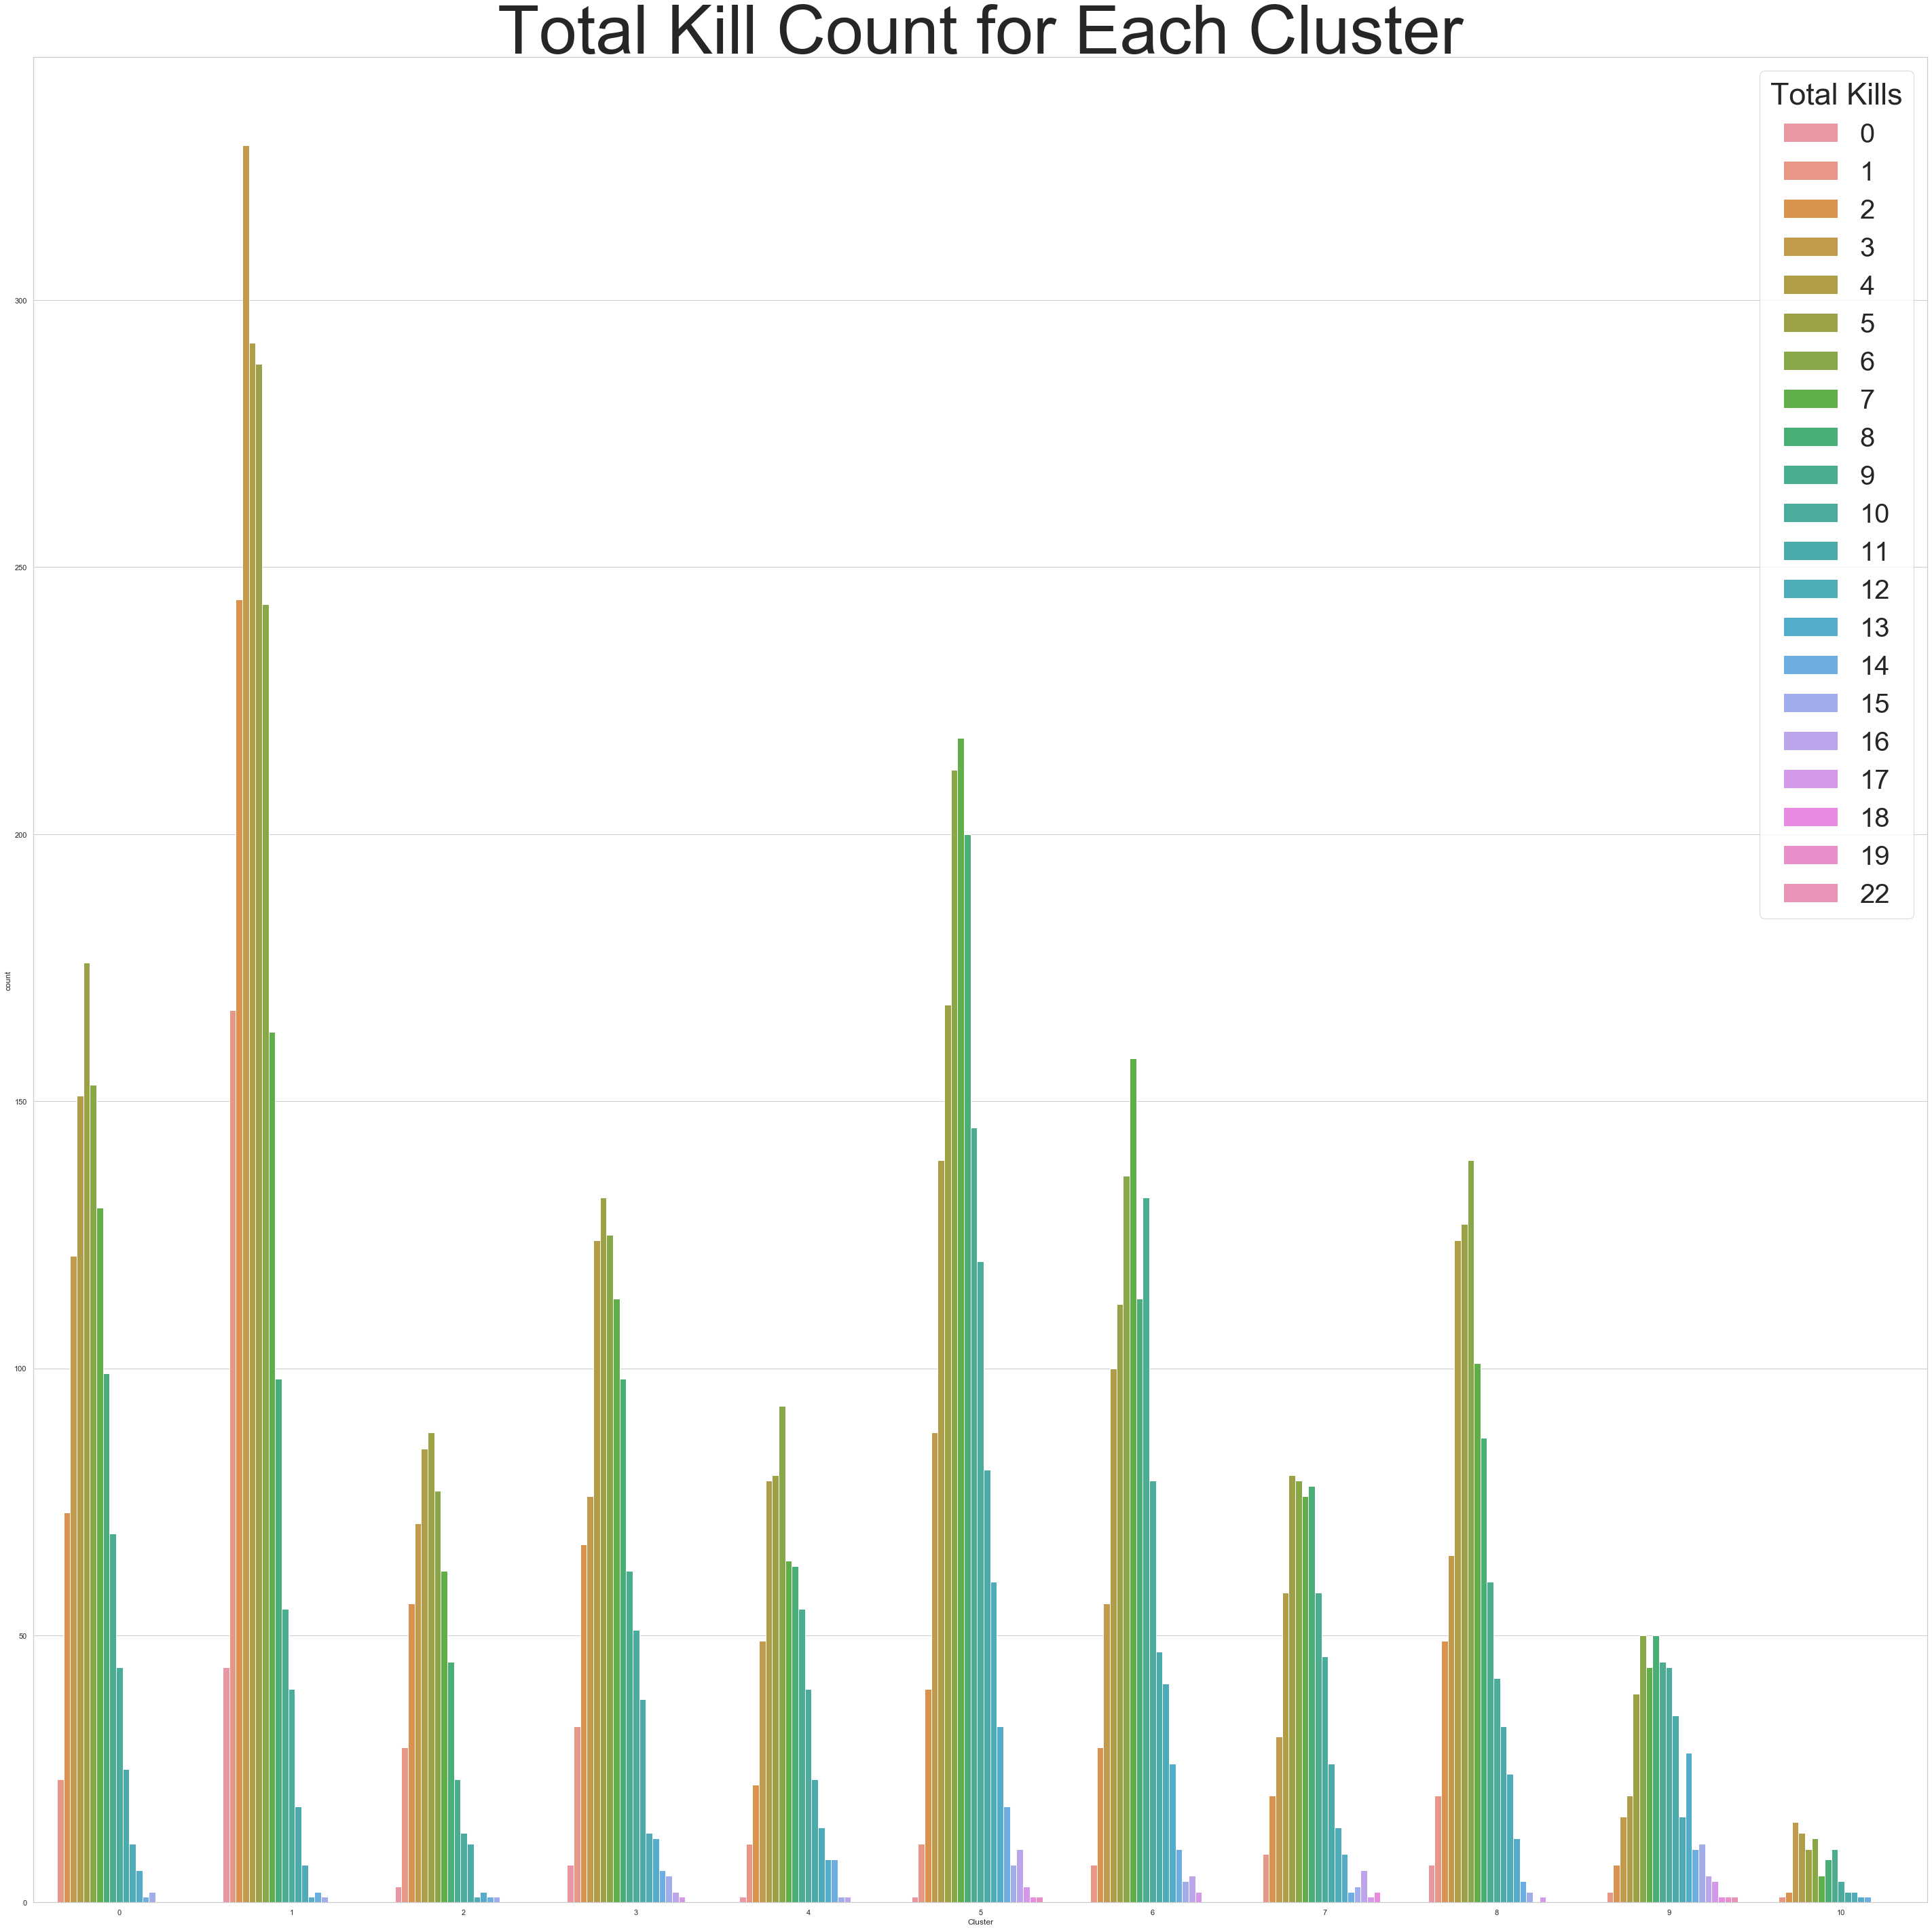

<IPython.core.display.Javascript object>

In [103]:
# Creating a bar plot to show total deaths in each cluster. Need to increase font size of each axis labels.
sns.countplot(data=blue_lol, x="Cluster", hue="blueKills")
plt.legend(
    loc="upper right", title="Total Kills", fontsize=40, title_fontsize=45,
)
sns.set(rc={"figure.figsize": (50, 50)})
sns.set_style("whitegrid")
plt.title("Total Kill Count for Each Cluster", fontsize=100)
plt.show()

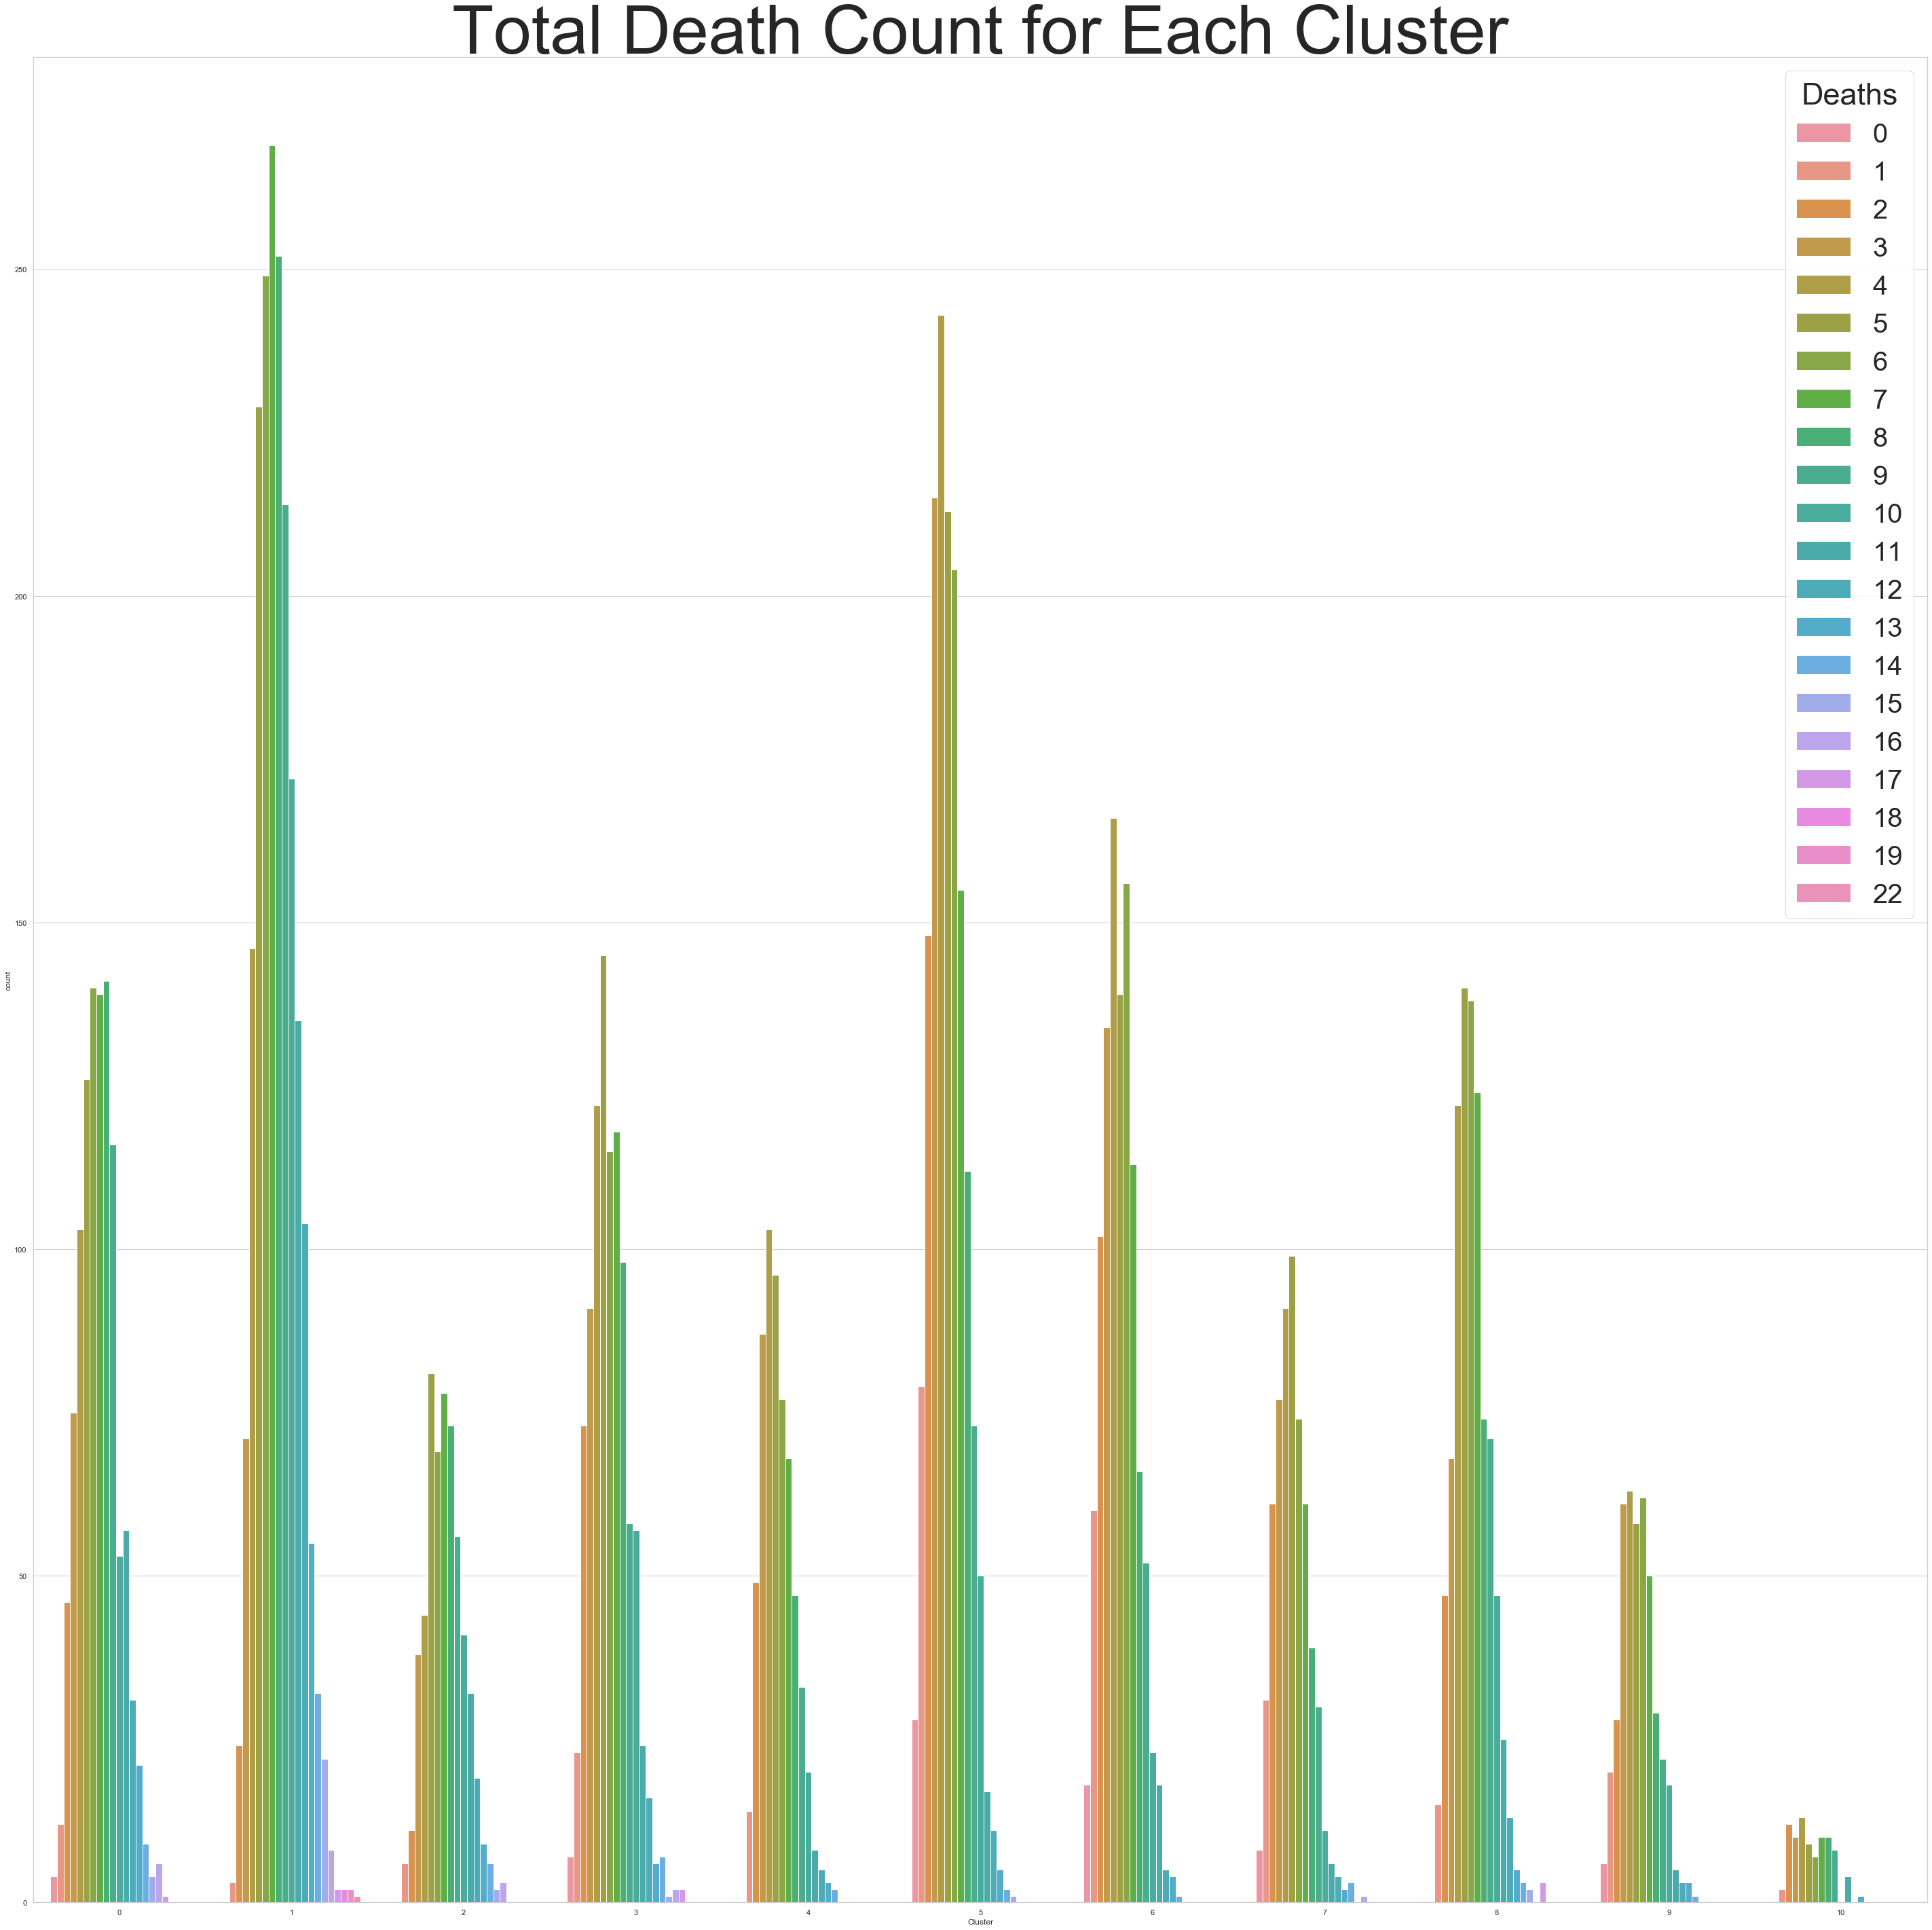

<IPython.core.display.Javascript object>

In [106]:
# Creating a bar plot to show total kills in each cluster. Need to increase font size of each axis labels.
sns.countplot(data=blue_lol, x="Cluster", hue="blueDeaths")
plt.legend(
    loc="upper right", title="Deaths", fontsize=40, title_fontsize=45,
)
sns.set(rc={"figure.figsize": (50, 50)})
sns.set_style("whitegrid")
plt.title("Total Death Count for Each Cluster", fontsize=100)
plt.show()

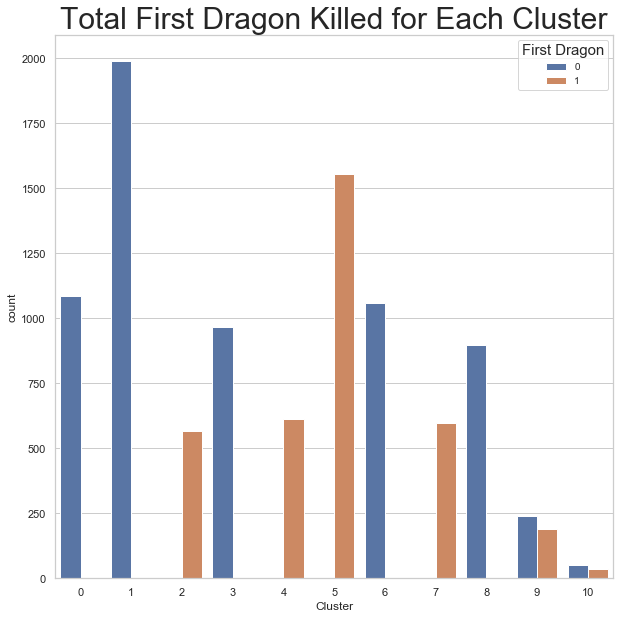

<IPython.core.display.Javascript object>

In [119]:
# Creating a bar plot to show total first dragons in each cluster. Need to increase font size of each axis labels.
sns.countplot(data=blue_lol, x="Cluster", hue="blueDragons")
plt.legend(
    loc="upper right", title="First Dragon", fontsize=10, title_fontsize=15,
)
sns.set(rc={"figure.figsize": (10, 10)})
sns.set_style("whitegrid")
plt.title("Total First Dragon Killed for Each Cluster", fontsize=30)
plt.show()

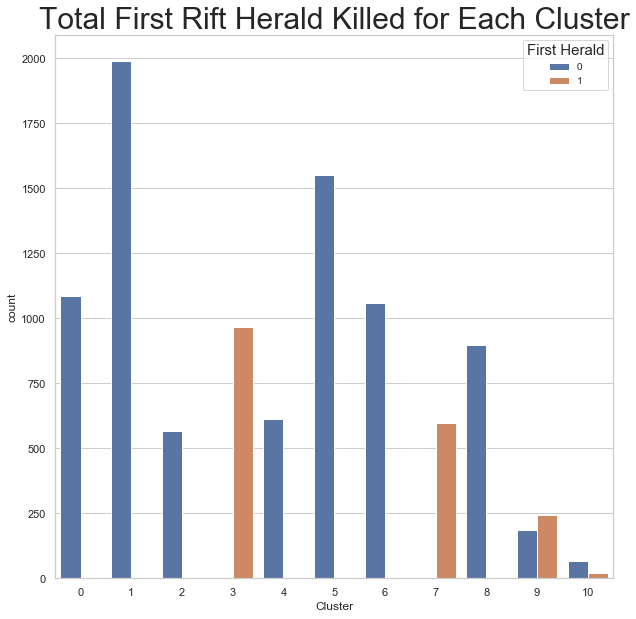

<IPython.core.display.Javascript object>

In [121]:
# Creating a bar plot to show total first dragons in each cluster. Need to increase font size of each axis labels.
sns.countplot(data=blue_lol, x="Cluster", hue="blueHeralds")
plt.legend(
    loc="upper right", title="First Herald", fontsize=10, title_fontsize=15,
)
sns.set(rc={"figure.figsize": (10, 10)})
sns.set_style("whitegrid")
plt.title("Total First Rift Herald Killed for Each Cluster", fontsize=30)
plt.show()

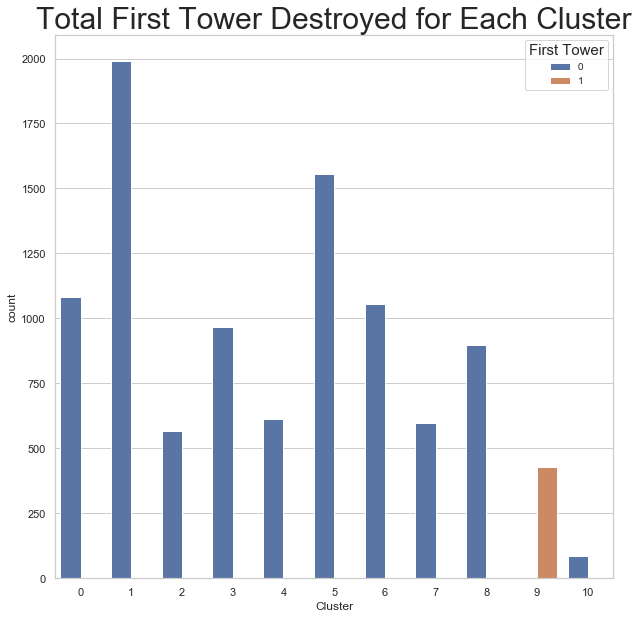

<IPython.core.display.Javascript object>

In [122]:
sns.countplot(data=blue_lol, x="Cluster", hue="blueTowersDestroyed")
plt.legend(
    loc="upper right", title="First Tower", fontsize=10, title_fontsize=15,
)
sns.set(rc={"figure.figsize": (10, 10)})
sns.set_style("whitegrid")
plt.title("Total First Tower Destroyed for Each Cluster", fontsize=30)
plt.show()

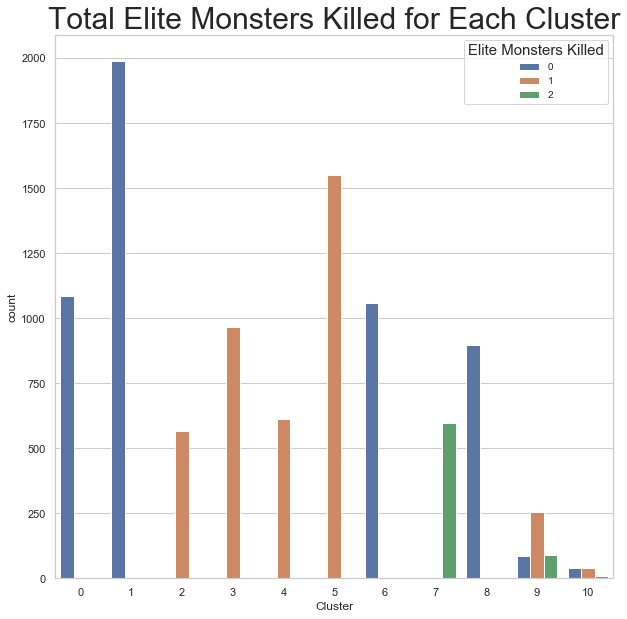

<IPython.core.display.Javascript object>

In [123]:
sns.countplot(data=blue_lol, x="Cluster", hue="blueEliteMonsters")
plt.legend(
    loc="upper right", title="Elite Monsters Killed", fontsize=10, title_fontsize=15,
)
sns.set(rc={"figure.figsize": (10, 10)})
sns.set_style("whitegrid")
plt.title("Total Elite Monsters Killed for Each Cluster", fontsize=30)
plt.show()

In [94]:
# # Trying to use plotly to create more appealing visuals, will most likely come back to this and fix it up
# ibarchart(blue_lol, "Cluster", "blueWins", title="Wins by Cluster")

<IPython.core.display.Javascript object>

In [95]:
# # Trying to use plotly to create more appealing visuals, will most likely come back to this and fix it up
# ibarchart(blue_lol, "Cluster", "blueWardsPlaced", title="Wards Placed by Cluster")

<IPython.core.display.Javascript object>

In [96]:
# # Trying to use plotly to create more appealing visuals, will most likely come back to this and fix it up
# ibarchart(blue_lol, "Cluster", "blueWardsDestroyed", title="Wards Destroyed by Cluster")

<IPython.core.display.Javascript object>

In [97]:
# # Trying to use plotly to create more appealing visuals, will most likely come back to this and fix it up
# ibarchart(blue_lol, "Cluster", "blueFirstBlood", title="Total First Bloods by Cluster")

<IPython.core.display.Javascript object>

In [98]:
# # Trying to use plotly to create more appealing visuals, will most likely come back to this and fix it up
# ibarchart(blue_lol, "Cluster", "blueKills", title="Kills by Cluster")

<IPython.core.display.Javascript object>

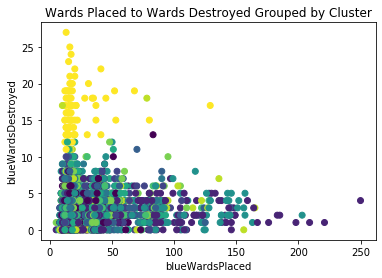

<IPython.core.display.Javascript object>

In [60]:
# Need to add legend
plt.scatter(
    x="blueWardsPlaced", y="blueWardsDestroyed", c="Cluster", data=blue_lol,
)
plt.title("Wards Placed to Wards Destroyed Grouped by Cluster")
plt.xlabel("blueWardsPlaced")
plt.ylabel("blueWardsDestroyed")
plt.show()

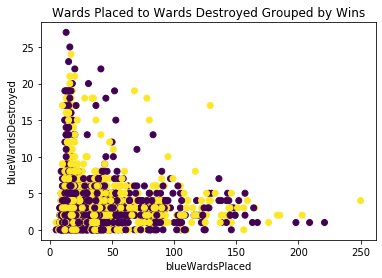

<IPython.core.display.Javascript object>

In [61]:
# Need to add legend
plt.scatter(
    x="blueWardsPlaced", y="blueWardsDestroyed", c="blueWins", data=blue_lol,
)
plt.title("Wards Placed to Wards Destroyed Grouped by Wins")
plt.xlabel("blueWardsPlaced")
plt.ylabel("blueWardsDestroyed")
plt.show()

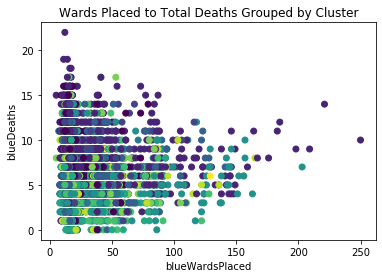

<IPython.core.display.Javascript object>

In [62]:
# Need to add legend
plt.scatter(
    x="blueWardsPlaced", y="blueDeaths", c="Cluster", data=blue_lol,
)
plt.title("Wards Placed to Total Deaths Grouped by Cluster")
plt.xlabel("blueWardsPlaced")
plt.ylabel("blueDeaths")
plt.show()

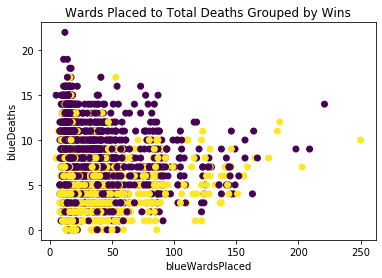

<IPython.core.display.Javascript object>

In [63]:
# Need to add legend
plt.scatter(
    x="blueWardsPlaced", y="blueDeaths", c="blueWins", data=blue_lol,
)
plt.title("Wards Placed to Total Deaths Grouped by Wins")
plt.xlabel("blueWardsPlaced")
plt.ylabel("blueDeaths")
plt.show()

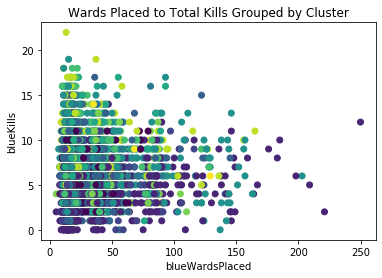

<IPython.core.display.Javascript object>

In [64]:
# Need to add legend
plt.scatter(
    x="blueWardsPlaced", y="blueKills", c="Cluster", data=blue_lol,
)
plt.title("Wards Placed to Total Kills Grouped by Cluster")
plt.xlabel("blueWardsPlaced")
plt.ylabel("blueKills")
plt.show()

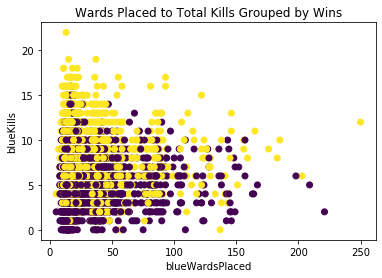

<IPython.core.display.Javascript object>

In [65]:
# Need to add legend
plt.scatter(
    x="blueWardsPlaced", y="blueKills", c="blueWins", data=blue_lol,
)
plt.title("Wards Placed to Total Kills Grouped by Wins")
plt.xlabel("blueWardsPlaced")
plt.ylabel("blueKills")
plt.show()

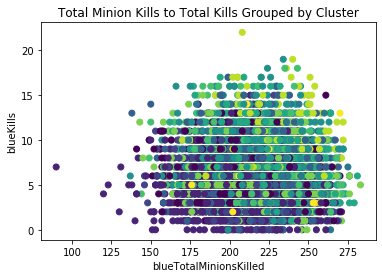

<IPython.core.display.Javascript object>

In [66]:
# Need to add legend
plt.scatter(
    x="blueTotalMinionsKilled", y="blueKills", c="Cluster", data=blue_lol,
)
plt.title("Total Minion Kills to Total Kills Grouped by Cluster")
plt.xlabel("blueTotalMinionsKilled")
plt.ylabel("blueKills")
plt.show()

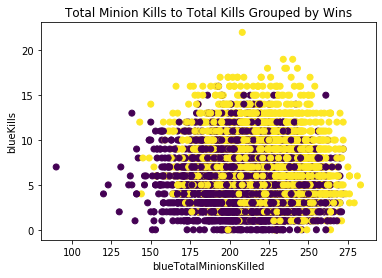

<IPython.core.display.Javascript object>

In [67]:
# Need to add legend
plt.scatter(
    x="blueTotalMinionsKilled", y="blueKills", c="blueWins", data=blue_lol,
)
plt.title("Total Minion Kills to Total Kills Grouped by Wins")
plt.xlabel("blueTotalMinionsKilled")
plt.ylabel("blueKills")
plt.show()

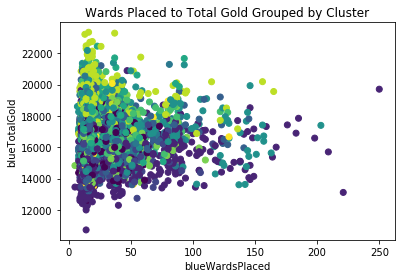

<IPython.core.display.Javascript object>

In [68]:
# Need to add legend
plt.scatter(
    x="blueWardsPlaced", y="blueTotalGold", c="Cluster", data=blue_lol,
)
plt.title("Wards Placed to Total Gold Grouped by Cluster")
plt.xlabel("blueWardsPlaced")
plt.ylabel("blueTotalGold")
plt.show()

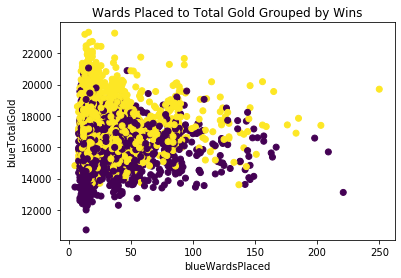

<IPython.core.display.Javascript object>

In [69]:
# Need to add legend
plt.scatter(
    x="blueWardsPlaced", y="blueTotalGold", c="blueWins", data=blue_lol,
)
plt.title("Wards Placed to Total Gold Grouped by Wins")
plt.xlabel("blueWardsPlaced")
plt.ylabel("blueTotalGold")
plt.show()

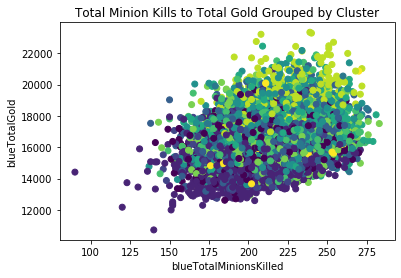

<IPython.core.display.Javascript object>

In [70]:
# Need to add legend
plt.scatter(
    x="blueTotalMinionsKilled", y="blueTotalGold", c="Cluster", data=blue_lol,
)
plt.title("Total Minion Kills to Total Gold Grouped by Cluster")
plt.xlabel("blueTotalMinionsKilled")
plt.ylabel("blueTotalGold")
plt.show()

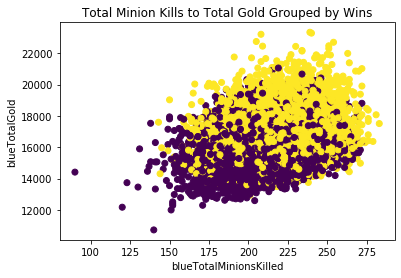

<IPython.core.display.Javascript object>

In [71]:
# Need to add legend
plt.scatter(
    x="blueTotalMinionsKilled", y="blueTotalGold", c="blueWins", data=blue_lol,
)
plt.title("Total Minion Kills to Total Gold Grouped by Wins")
plt.xlabel("blueTotalMinionsKilled")
plt.ylabel("blueTotalGold")
plt.show()

In [73]:
fields = [
    "blueWardsPlaced",
    "blueWardsDestroyed",
    "blueFirstBlood",
    "blueKills",
    "blueDeaths",
    "blueAssists",
    "blueEliteMonsters",
    "blueDragons",
    "blueHeralds",
    "blueTowersDestroyed",
    "blueTotalGold",
    "blueTotalExperience",
    "blueTotalMinionsKilled",
    "blueTotalJungleMinionsKilled",
]

<IPython.core.display.Javascript object>

In [74]:
# wrap code for creating interactive scatterplots
def iscatter(df, x, y, color=None, size=None, title=""):
    fig = px.scatter(df, x=x, y=y, color=color, size=size, title=title, template="none")

    #     for item in range(len(fig.data)):
    #         fig.data[item].update(name=fig.data[item]["name"].split("=")[1])

    fig.update_traces(marker_line_color="black", marker_line_width=1)

    fig.show()

<IPython.core.display.Javascript object>

In [75]:
# Trying to add an interactive plot, getting error.
@interact(X_Axis=sorted(fields), Y_Axis=sorted(fields, reverse=True))
def viz(X_Axis, Y_Axis):
    iscatter(
        blue_lol,
        X_Axis,
        Y_Axis,
        color="Cluster",
        title=f"Relationship between {X_Axis} and {Y_Axis}",
    )

interactive(children=(Dropdown(description='X_Axis', options=('blueAssists', 'blueDeaths', 'blueDragons', 'blu…

<IPython.core.display.Javascript object>